# RNN Model Train Step (Etapa do Treinamento do Modelo LSTM)
**[EN-US]**

Training and evaluation stage of the LSTM model, and then we save the model and its respective trained weights, and use it to make predictions on real-world data.

In this step we perform:
* Model definition;
* Model training;
* Model evaluation;
* Saving the model and trained weights.

**[PT-BR]**

Etapa do treinamento e avaliação do modelo LSTM, para depois, salvarmos o modelo e seus respectivos pesos treinados, e usarmos para realizar a predição em dados do mundo real.

Nesta etapa realizamos:
* Definição do modelo;
* Treinamento do modelo;
* Avaliação do modelo;
* Salvamento do modelo e dos pesos treinados.

## Table of Contents
* [Packages](#1)
* [Setting](#2)
* [RNN Model](#3)
    * [Embedding](#3.1)
    * [LSTM Layer](#3.2)
* [LSTM Model Train](#4)

<a name="1"></a>
## Packages (Pacotes)
**[EN-US]**

Packages used in the system.

* [pandas](https://pandas.pydata.org/): is the main package for data manipulation;
* [numpy](www.numpy.org): is the main package for scientific computing;
* [pickle](https://docs.python.org/3/library/pickle.html): implements binary protocols for serializing and de-serializing a Python object structure;
* [tensorflow](https://www.tensorflow.org/): framework that makes it easy to create ML models that can run in any environment;
* [matplotlib](http://matplotlib.org): is a library to plot graphs;
* [os](https://docs.python.org/3/library/os.html): built-in module, provides a portable way of using operating system dependent functionality;
* [sys](https://docs.python.org/3/library/sys.html): provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter;
* [src](../src/): package with all the codes for all utility functions created for this system.

**[PT-BR]**

Pacotes utilizados no sistema.
* [pandas](https://pandas.pydata.org/): é o principal pacote para manipulação de dados;
* [numpy](www.numpy.org): é o principal pacote para computação científica;
* [pickle](https://docs.python.org/3/library/pickle.html): implementa protocolos binários para serializar e desserializar uma estrutura de objeto Python;
* [tensorflow](https://www.tensorflow.org/): framework que facilita a criação de modelos de machine learning que podem ser executados em qualquer ambiente;
* [matplotlib](http://matplotlib.org): é uma biblioteca para plotar gráficos;
* [os](https://docs.python.org/3/library/os.html): módulo integrado, fornece uma maneira portátil de usar funcionalidades dependentes do sistema operacional;
* [sys](https://docs.python.org/3/library/sys.html): fornece acesso a algumas variáveis usadas ou mantidas pelo interpretador e a funções que interagem fortemente com o interpretador;
* [src](../src/): pacote com todos os códigos de todas as funções utilitárias criadas para esse sistema.

In [4]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session

import os
import sys
PROJECT_ROOT = os.path.abspath( # Getting Obtaining the absolute normalized version of the project root path (Obtendo a versão absoluta normalizada do path raíz do projeto)
    os.path.join( # Concatenating the paths (Concatenando os paths)
        os.getcwd(), # # Getting the path of the notebooks directory (Obtendo o path do diretório dos notebooks)
        os.pardir # Gettin the constant string used by the OS to refer to the parent directory (Obtendo a string constante usada pelo OS para fazer referência ao diretório pai)
    )
)
# Adding path to the list of strings that specify the search path for modules
# Adicionando o path à lista de strings que especifica o path de pesquisa para os módulos
sys.path.append(PROJECT_ROOT)
from src.rnn_model_train import *

**[EN-US]**

> **Note**: the codes for the utility functions used in this system are in the `rnn_model_train.py` script within the `../src/` directory.

**[PT-BR]**

> **Nota**: os códigos para as funções utilitárias utilizadas nesse sistema estão no script `rnn_model_train.py` dentro do diretório `../src/`.

<a name="2"></a>
## Setting (Configurando)
**[EN-US]**

We will read each subset from disk, define the global variables for creating the dataset and model, and we will create the `tensorflow.data.Dataset` for each subset.

Reading each of the subsets from the `../data/preprocessed/` directory and plotting their dimensions.

**[PT-BR]**

Vamos ler cada subset do disco, definir as variáveis globais para a criação do dataset e do modelo, e vamos criar o `tensorflow.data.Dataset` de cada subset.

Lendo cada um dos subsets do diretório `../data/preprocessed/` e plotando as suas dimensões.

In [8]:
# Subset names (nomes dos subsets)
files = ['train', 'valid', 'test']
datasets = []
# Looping through each name (Percorrendo cada nome)
for file in files:
    # Reading each subset and adding it to the list for later extraction
    # Lendo cada subset e adicionando na lista para extração posteriormente
    with open(f'../data/preprocessed/{file}_tokens.npy', 'rb') as f:
        datasets.append(np.load(f))

# Extracting each subset from the `datasets` list
# Extraindo cada subset da lista `datasets`
train_corpus, valid_corpus, test_corpus = datasets
print(f'Train set shape: {train_corpus.shape}\nValidation set shape: {valid_corpus.shape}\nTest set shape: {test_corpus.shape}')

Train set shape: (9682, 167)
Validation set shape: (3227, 167)
Test set shape: (3228, 167)


**[EN-US]**

Setting global variables to create `tensorflow.data.Dataset` and global variables to create the model.

**[PT-BR]**

Definindo as variáveis globais para criar o `tensorflow.data.Dataset` e as variáveis globais para a criação do modelo.

In [11]:
# Dataset global variables
# Variáveis globais do dataset
BATCH_SIZE = 128
BUFFER_SIZE = 1000

# Model global variables
# Variáveis globais do modelo
MAX_LEN = train_corpus.shape[1] - 1
EMBEDDING_DIM = 5000
DROPOUT_RATE = .1
# Loading vocabulary from trained tokenizer
# Carregando o vocabulário do tokenizer treinado
VOCAB_SIZE = len(pickle.load(open('../models/vectorizer.pkl', 'rb'))['vocabulary'])

Creating `tensorflow.data.Dataset` for each subset and plotting the training set dimension (Criando o `tensorflow.data.Dataset` para cada subset e plotando a dimensão do training set).

In [14]:
train_set = create_batch_dataset(train_corpus, BATCH_SIZE, BUFFER_SIZE, shuffle=True)
valid_set = create_batch_dataset(valid_corpus, BATCH_SIZE, BUFFER_SIZE)
test_set = create_batch_dataset(test_corpus, BATCH_SIZE, BUFFER_SIZE)

train_batch = next(train_set.as_numpy_iterator())
print(f"Shape of the train batch: {train_batch[0].shape}")

Shape of the train batch: (128, 166)


<a name="3"></a>
## RNN Model (Modelo RNN)
**[EN-US]**



**[PT-BR]**

<a name="3.1"></a>
### Embedding
**[EN-US]**



**[PT-BR]**

<a name="3.2"></a>
### LSTM Layer
**[EN-US]**



**[PT-BR]**

<a name="4"></a>
## LSTM Model Train (Treinamento do Modelo LSTM)
**[EN-US]**



**[PT-BR]**

In [20]:
def create_and_compile_model(input_shape, vocab_size, embedding_dim=1000, dropout_rate=.1, lr=1e-3, lambda_r=1e-2):
    """
    [EN-US]

    [PT-BR]
    
    """
    # Clearing all internal variables 
    # Limpando todas as variáveis internas
    clear_session()
    
    # Defining the model architecture
    # Definindo a arquitetura do modelo    
    input_layer = Input(shape=(input_shape,))
    embedding_layer = Embedding(vocab_size, embedding_dim, name='embedding_layer')(input_layer)
    X = Bidirectional(LSTM(32, return_sequences=True), name='bi_lstm_layer_1')(embedding_layer)
    X = Dropout(rate=dropout_rate, name='dropout_layer_1')(X)
    #X = GlobalAveragePooling1D()(X)
    X = Bidirectional(LSTM(16), name='bi_lstm_layer_2')(X)
    X = Dropout(rate=dropout_rate, name='dropout_layer_2')(X)
    X = Dense(16, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(lambda_r), name='dense_layer_1')(X)
    X = Dense(16, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(lambda_r), name='dense_layer_2')(X)
    output = Dense(1, activation='sigmoid', name='output_layer')(X)
    # Setting the input and output of the model
    # Definindo o input e o output do modelo
    model = Model(inputs=input_layer, outputs=output, name='LSTM_Bidirectional')

    # Compiling the model
    # Compilando o modelo
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', 'auc']
    )

    return model

In [22]:
EMBEDDING_DIM = 100
DROPOUT_RATE = .5

model = create_and_compile_model(
    MAX_LEN, 
    VOCAB_SIZE, 
    EMBEDDING_DIM, 
    dropout_rate=DROPOUT_RATE, 
    lr=1e-2
)
model.summary()

Model: "LSTM_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 166)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 166, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_layer_1 (Bidirectional) │ (None, 166, 64)        │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 166, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_layer_2 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_2 (Dropout)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,233 (3.99 MB)

 Trainable params: 1,045,233 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

**[EN-US]**

Defining the callbacks that will be used in training and training the model. The callbacks are:
* `ModelCheckpoint`: saves model checkpoints at regular intervals during training, by default at the end of each epoch. If we use a validation set during training, we can set `save_best_only=True` and it will only save our model when the performance on the validation set so far is the best.
* `EarlyStopping`: one of the ways to implement early stopping, that is, we stop training when the model does not calculate any progress in the validation defined by some epochs, defined by the `patience` argument and, optionally, will revert to the best model, defined by the `restore_best_weights` argument.

**[PT-BR]**

Definindo os callbacks que serão utilizados no treinamento e treinando o modelo. Os callbacks são:
* `ModelCheckpoint`: salva os checkpoints do modelo em intervalos regulares durante o treinamento, por padrão no fim de cada epoch. Se utilizarmos um validation set durante o treinamento, podemos definir `save_best_only=True` e ele apenas salvará nosso modelo quando o desempenho no validation set até então for o melhor.
* `EarlyStopping`: uma das formas de implementarmos a early stopping, ou seja, interrompemos o treinamento quando o modelo não calcular nenhum progresso na validação definida por algumas epochs, definido pelo argumento `patience` e, opcionalmente, reverterá para o melhor modelo, definido pelo argumento `restore_best_weights`.

In [24]:
# Setting the callbacks
# Definindo os callbacks
checkpoint_cb = ModelCheckpoint('../models/lstm_model.keras', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=50, restore_best_weights=True)

# Training the model
# Treinando o modelo
history = model.fit(
    train_set,
    epochs=25,
    validation_data=valid_set,
    callbacks=[checkpoint_cb, early_stopping_cb],
    verbose=2
)

Epoch 1/25
76/76 - 26s - 337ms/step - accuracy: 0.6245 - auc: 0.5832 - loss: 0.8147 - val_accuracy: 0.5928 - val_auc: 0.5044 - val_loss: 0.6955
Epoch 2/25
76/76 - 10s - 128ms/step - accuracy: 0.6883 - auc: 0.7302 - loss: 0.5992 - val_accuracy: 0.5407 - val_auc: 0.5070 - val_loss: 0.7130
Epoch 3/25
76/76 - 10s - 135ms/step - accuracy: 0.7592 - auc: 0.8053 - loss: 0.5288 - val_accuracy: 0.5330 - val_auc: 0.4956 - val_loss: 0.8305
Epoch 4/25
76/76 - 10s - 135ms/step - accuracy: 0.8167 - auc: 0.8670 - loss: 0.4458 - val_accuracy: 0.5095 - val_auc: 0.4943 - val_loss: 0.9147
Epoch 5/25
76/76 - 10s - 130ms/step - accuracy: 0.8593 - auc: 0.9064 - loss: 0.3760 - val_accuracy: 0.5005 - val_auc: 0.5013 - val_loss: 1.0187
Epoch 6/25
76/76 - 10s - 128ms/step - accuracy: 0.8872 - auc: 0.9285 - loss: 0.3246 - val_accuracy: 0.5169 - val_auc: 0.5004 - val_loss: 1.1440
Epoch 7/25
76/76 - 10s - 136ms/step - accuracy: 0.9042 - auc: 0.9411 - loss: 0.2893 - val_accuracy: 0.5249 - val_auc: 0.4976 - val_loss:

Plotting loss and evaluation metrics during model training (Plotando a loss e a métrica de avaliação durante o treinamento do modelo).

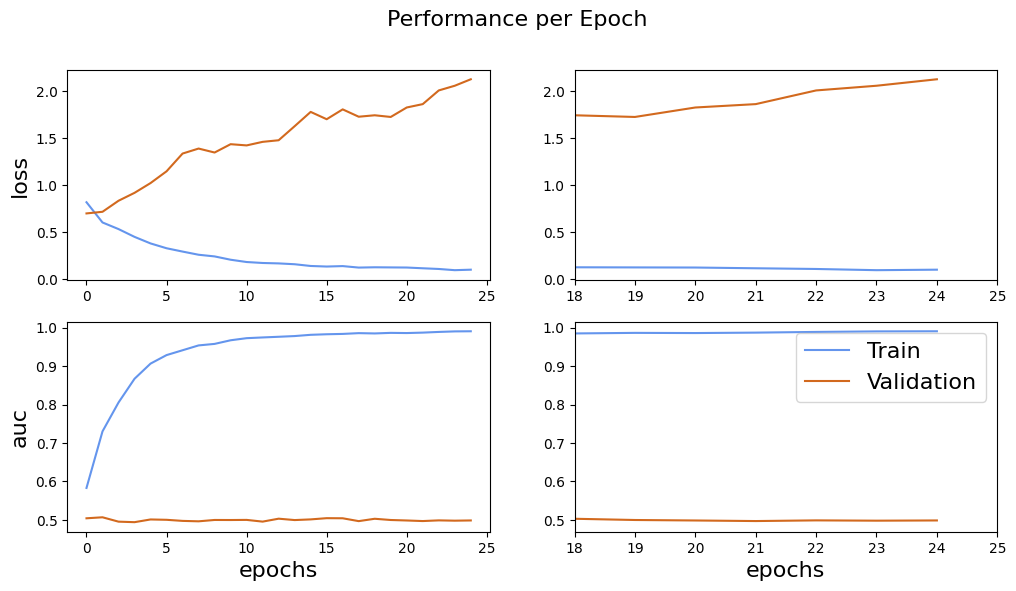

In [35]:
plot_history(history, 'auc', name='model_history')

In [30]:
print(f'Train set evaluate: {model.evaluate(train_set, verbose=0)}')
print(f'Validation set evaluate: {model.evaluate(valid_set, verbose=0)}')

Train set evaluate: [0.6323050856590271, 0.6272464394569397, 0.7420925498008728]
Validation set evaluate: [0.6955096125602722, 0.5928106307983398, 0.5043700933456421]


In [29]:
print(f'Test set evaluate: {model.evaluate(test_set, verbose=0)[1]:.4f}')

Test set evaluate: 0.5818
